In [4]:
import loren_frank_data_processing as lfdp
import replay_classification as replay
import ripple_detection as ripple
import matplotlib.pyplot as plt
import holoviews as hv
import inspect
import os
import pandas as pd
import numpy as np
from ipywidgets import FloatProgress
from IPython.display import display
import functools
hv.notebook_extension('bokeh')
%matplotlib inline
%reload_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'replay_classification'

In [2]:
animal_id = 'JZ1'
day, epoch = [1, 2]
ripple_area = 'ca1'
mu_areas = ['ca1', 'mec']
animals = {
    'JZ1': lfdp.Animal(short_name='JZ1', directory='../Raw-Data/JZ1')}
date = 20161114
epoch_index = ('JZ1', 1, 2)
areas = ['ca1']
mark_variables = ['channel_1_max', 'channel_2_max', 'channel_3_max',
                  'channel_4_max']

In [142]:
os.system('subl {0}'.format('~/anaconda3/envs/Roumis_2018/lib/python3.6/site-packages/loren_frank_data_processing/utilities.py'))
# os.system('subl ~/anaconda3/envs/Roumis_2018/lib/python3.6/site-packages/loren_frank_data_processing/tetrodes.py')

0

In [3]:
from src.parameters import ANIMALS
epoch_info = lfdp.make_epochs_dataframe(ANIMALS)

In [ ]:
ntrode_df = lfdp.make_tetrode_dataframe(animals)
ntrode_keys = ntrode_df.xs(epoch_index, drop_level=False).index.values
ntrodes = ntrode_df.xs(
    epoch_index, drop_level=False
).index.get_level_values('tetrode_number').tolist()

In [147]:
mec_ntrode_df = ntrode_df.xs(
    epoch_index, drop_level=False
).query('area == "mec"')

In [11]:
ca1_ntrode_df = ntrode_df.xs(
    epoch_index, drop_level=False
).query('area == "ca1"')

In [5]:
position_variables = ['linear_distance', 'trajectory_direction', 'speed']
position_df = lfdp.get_interpolated_position_dataframe(epoch_index, animals)
# add the time index values as another col
position_df['time'] = position_df.index

In [6]:
f = FloatProgress(min=0, max=ntrode_keys.shape[0])
f.value = 0
display(f)
mu_df = []
for key_num, ntrode_key in enumerate(ntrode_keys):
    mu_df.append(lfdp.get_multiunit_indicator_dataframe(ntrode_key, animals))
    f.value += 1

FloatProgress(value=0.0, max=30.0)

In [221]:
muind = mu_df[0].index

In [ ]:
muind.total_seconds

# per minute chunk marks

In [7]:
%autoreload 2
from src.data_iterators import minute_linspaced_epoch_times, chunk_mark_timeseries

In [8]:
ntrode_key = ('JZ1', 1, 2, 16)

In [235]:
linspaced_times = minute_linspaced_epoch_times(animals, epoch_index)

In [248]:
mark_linspace_chunks = chunk_mark_timeseries(mark_times, ntrodes, linspaced_times, position_df,
                          resample_time='1ms')

In [250]:
mark_linspace_chunks.head()

segment_ID segment_type area      start_time        end_time  \
0           0          NaN  NaN 00:28:00.085200 00:29:00.085200   
1           1          NaN  NaN 00:29:00.085200 00:30:00.085200   
2           2          NaN  NaN 00:30:00.085200 00:31:00.085200   
3           3          NaN  NaN 00:31:00.085200 00:32:00.085200   
4           4          NaN  NaN 00:32:00.085200 00:33:00.085200   

                                               marks ntrodes  \
0                      channel_1_max  channel_2_m...     NaN   
1                      channel_1_max  channel_2_m...     NaN   
2                      channel_1_max  channel_2_m...     NaN   
3                      channel_1_max  channel_2_m...     NaN   
4                      channel_1_max  channel_2_m...     NaN   

                                     linear_position times  
0                   labeled_segments from_well to...   NaN  
1                   labeled_segments from_well to...   NaN  
2                   labeled_segments from_well to...   NaN  
3                   labeled_segments from_well to...   NaN  
4                   labeled_segments from_well to...   NaN

# Ripple Marks

In [205]:
hippocampus_lfps = lfdp.get_LFPs(ca1_ntrode_df.index, animals)
time = hippocampus_lfps.index
sampling_frequency = 1500
ripple_times = ripple.Kay_ripple_detector(
    time, hippocampus_lfps.values, position_df.speed.values, sampling_frequency,
    minimum_duration=pd.Timedelta(milliseconds=15), zscore_threshold=4)

In [724]:
def get_ntrode_spikes_dmap_local(event_times, spike_times, ntrode=1):
    import pandas as pd
    '''per ntrode, event-triggered spike raster as Holoviews DynamicMap

    Parameters
    ----------
    ntrode_number : int, default 0 for initialization
    ntrodes : list of ints
    event_times : pd.DataFrame, columns=['start_time', 'end_time']
    spike_times : pd.DataFrame, index=timedelta labeled 'time'
    window : float

    Returns
    -------
    Spikes : Holoviews Spikes element

    '''
    events = np.arange(1,event_times.shape[0]+1)
    window_spikes = pd.DataFrame(pd.concat([(spike_times[ntrode].dropna()[(rv.start_time-timedelta(seconds=.5)):(rv.start_time+timedelta(seconds=.5))].reset_index()['time'] - rv.start_time).dt.total_seconds()
                 for irip, rv in event_times.iterrows()
                 ], keys=events, names=['event_number'])).reset_index()

    Spikes = {}
    for irip, ripvals in event_times.iterrows():
        Spikes[irip] = hv.Spikes(window_spikes[window_spikes.event_number == irip].time,
         kdims = 'time',  group = 'SWR-trig_multi-unit').opts(plot = dict(position = irip))

    Spikes_dmap = hv.NdOverlay(overlays=Spikes, kdims=['event_number']).opts(plot = dict(yticks = events))

    return Spikes_dmap

In [725]:
func_local = functools.partial(get_ntrode_spikes_dmap_local, event_times, mu_df)
spikes_dmap_local = hv.DynamicMap(func_local, kdims=['ntrode']).redim.range(ntrode=((1,30)))

In [726]:
%%opts Spikes {+framewise} [height=400 width=600] 
# bgcolor='white' spike_length=10] (line_width=1)
spikes_dmap_local

:DynamicMap   [ntrode]

In [87]:
%autoreload 2
import src.visualization as viz
from src.data_iterators import get_ntrode_event_spikes

In [40]:
window_spikes = get_ntrode_event_spikes(ripple_times, mu_df, ntrodes, window=.4)

KeyboardInterrupt: 

In [96]:
window_spikes[2].head(100)
df = pd.DataFrame({"a": np.random.random_integers(0, high=100, size=100)})
ranges = [0,10,20,30,40,50,60,70,80,90,100]
df.groupby(pd.cut(df.a, ranges)).count()

event_number  level_1      time
0              1        0 -0.395334
1              1        1 -0.390000
2              1        2 -0.385334
3              1        3 -0.384667
4              1        4 -0.384000
5              1        5 -0.383334
6              1        6 -0.380000
7              1        7 -0.374667
8              1        8 -0.368000
9              1        9 -0.367334
10             1       10 -0.366667
11             1       11 -0.364667
12             1       12 -0.362667
13             1       13 -0.348667
14             1       14 -0.348000
15             1       15 -0.347334
16             1       16 -0.346000
17             1       17 -0.344000
18             1       18 -0.342000
19             1       19 -0.335334
20             1       20 -0.334000
21             1       21 -0.330667
22             1       22 -0.328667
23             1       23 -0.327334
24             1       24 -0.326000
25             1       25 -0.323334
26             1       26 -0.318000
27             1       27 -0.315334
28             1       28 -0.314667
29             1       29 -0.308667
..           ...      ...       ...
70             1       70 -0.171334
71             1       71 -0.170667
72             1       72 -0.170000
73             1       73 -0.168000
74             1       74 -0.166667
75             1       75 -0.165334
76             1       76 -0.162667
77             1       77 -0.159334
78             1       78 -0.158000
79             1       79 -0.154000
80             1       80 -0.152667
81             1       81 -0.150667
82             1       82 -0.143334
83             1       83 -0.142000
84             1       84 -0.136000
85             1       85 -0.133334
86             1       86 -0.128667
87             1       87 -0.124667
88             1       88 -0.118000
89             1       89 -0.116667
90             1       90 -0.113334
91             1       91 -0.110000
92             1       92 -0.109334
93             1       93 -0.102667
94             1       94 -0.102000
95             1       95 -0.100000
96             1       96 -0.096000
97             1       97 -0.094667
98             1       98 -0.094000
99             1       99 -0.087334

[100 rows x 3 columns]

In [32]:
dict_spec = {'Spikes':{'style':dict(color='grey')}, 
             'Spikes.multiunit':{'style':dict(color='grey')}, 
             'Spikes.multiunit.ca1': {'style':dict(color='blue')}, # 'plot':dict(interpolation='steps-mid')},
             'Spikes.multiunit.mec': {'style':dict(color='purple')}}

In [70]:
dmapfunc = functools.partial(viz.get_ntrode_spikes_dmap,
                             ripple_times,
                             window_spikes,
                             epoch_index,
                             ntrode_df
                            )

In [91]:
spikes_dmap = hv.DynamicMap(dmapfunc, kdims=['ntrode']).redim.range(ntrode=((1,30)))#.opts(dict_spec)

In [89]:
swrline = hv.VLine((0))

In [149]:
%%opts Spikes {+framewise} [height=400 width=600 bgcolor='white' spike_length=1] (line_width=1 alpha=.2)
%%opts VLine (color='red' line_width=4, alpha=.1)
# %%opts Polygons {+framewise} (color='white' linewidth=10 alpha=.3)

spikes_dmap * swrline # * window_spikes[16].time.plot.kde()

:DynamicMap   [ntrode]

In [98]:
a = window_spikes[16]
apply_ranges=False

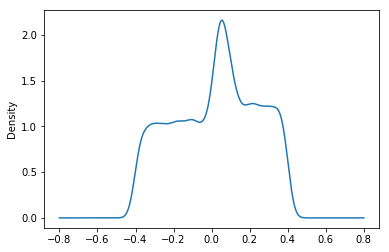

In [135]:
c = a.time.plot(kind='kde').get_children()

In [139]:
x = c[0]._x
y = c[0]._y

In [140]:
hv.Curve((x,y))

:Curve   [x]   (y)

In [202]:
epoch_key = ('JZ1', 1, 2)

In [210]:
neuron_info = lfdp.make_neuron_dataframe(ANIMALS).xs(epoch_key, drop_level=False)
neuron_info = pd.merge(
    neuron_info.reset_index('neuron_number'),
    ntrode_df.loc[:, ['area', 'subarea']], left_index=True, right_index=True
).set_index('neuron_number', append=True)
neuron_info

meanrate  numspikes  \
animal day epoch tetrode_number neuron_number                             
JZ1    1   2     2              1                 345.662322         42   
                 3              1                 172.831161         21   
                 10             1                7044.927323        856   
                                2                4049.187200        492   
                 12             1                  82.300553         10   
                 13             1               33175.352850       4031   
                 14             1                   8.230055          1   
                                2                   0.000000          0   
                                3                   0.000000          0   
                                4                 106.990719         13   
                 16             1                   8.230055          1   
                                2                1201.588071        146   
                                3                6682.804891        812   
                                4              474372.156516      57639   
                 17             1               21389.913683       2599   
                                2                6584.044227        800   
                 20             1                   8.230055          1   
                                2                 658.404423         80   
                                3                 197.521327         24   
                 24             1               19562.841410       2377   
                 26             1                   8.230055          1   
                 27             1               88440.174082      10746   
                                2              252498.096114      30680   
                 28             1               33907.827770       4120   
                                2               96011.824943      11666   
                                3               17875.680077       2172   
                                4               16056.837859       1951   
                                5               21719.115895       2639   
                                6               35060.035510       4260   
                                7               10756.682256       1307   
                                8               19291.249586       2344   
                                9                9423.413300       1145   

                                               spikewidth          neuron_id  \
animal day epoch tetrode_number neuron_number                                  
JZ1    1   2     2              1                     NaN  JZ1_01_02_002_001   
                 3              1                     NaN  JZ1_01_02_003_001   
                 10             1                     NaN  JZ1_01_02_010_001   
                                2                     NaN  JZ1_01_02_010_002   
                 12             1                     NaN  JZ1_01_02_012_001   
                 13             1                     NaN  JZ1_01_02_013_001   
                 14             1                     NaN  JZ1_01_02_014_001   
                                2                     NaN  JZ1_01_02_014_002   
                                3                     NaN  JZ1_01_02_014_003   
                                4                     NaN  JZ1_01_02_014_004   
                 16             1                     NaN  JZ1_01_02_016_001   
                                2                     NaN  JZ1_01_02_016_002   
                                3                     NaN  JZ1_01_02_016_003   
                                4                     NaN  JZ1_01_02_016_004   
                 17             1                     NaN  JZ1_01_02_017_001   
                                2                     NaN  JZ1_01_02_017_002   
                 20             1                     NaN  JZ

In [215]:
os.system('subl ~/anaconda3/envs/Roumis_2018/lib/python3.6/site-packages/loren_frank_data_processing/neurons.py')

0

In [218]:
spikes_df = lfdp.get_spikes_dataframe(mec_neuron_keys[0], animals)

NotImplementedError: Please use HDF reader for matlab v7.3 files

NotImplementedError: Please use HDF reader for matlab v7.3 files

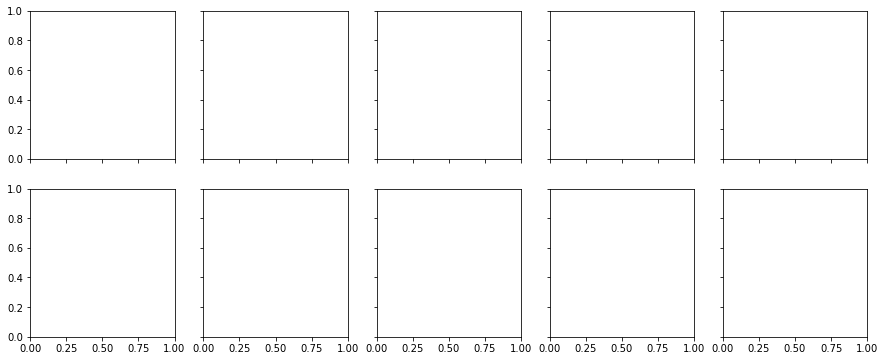

In [216]:
from src.visualization import plot_perievent_raster

mec_neuron_keys = neuron_info.query('area == "mec"').index
n_neurons = len(mec_neuron_keys)

col_wrap = 5
n_rows = np.ceil(n_neurons / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, neuron_key in zip(axes.ravel(), mec_neuron_keys):
    plot_perievent_raster(neuron_key, ANIMALS, ripple_times,
                          ntrode_df, window_offset=(-0.5, 0.5),
                          ax=ax, s=1)
    
for ax in axes.ravel()[n_neurons:]:
    ax.axis('off')

plt.tight_layout()

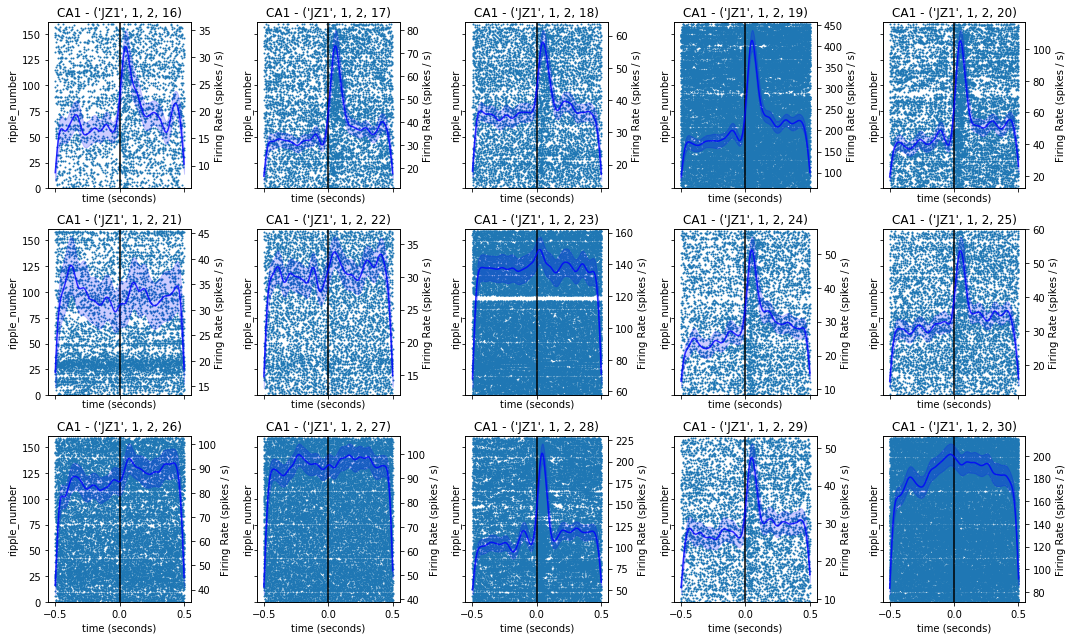

In [146]:
from src.visualization import plot_perievent_raster

ca1_keys = ca1_ntrode_df.index
n_tetrodes = len(ca1_keys)
col_wrap = 5
n_rows = np.ceil(n_tetrodes / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, tetrode_key in zip(axes.ravel(), ca1_keys):
    axplot, spikes, event_locked_spikes, kde = plot_perievent_raster(tetrode_key, ANIMALS, ripple_times,
                          ntrode_df, window_offset=(-0.5, 0.5),
                          ax=ax, s=1)
    
for ax in axes.ravel()[n_tetrodes:]:
    ax.axis('off')
plt.tight_layout()

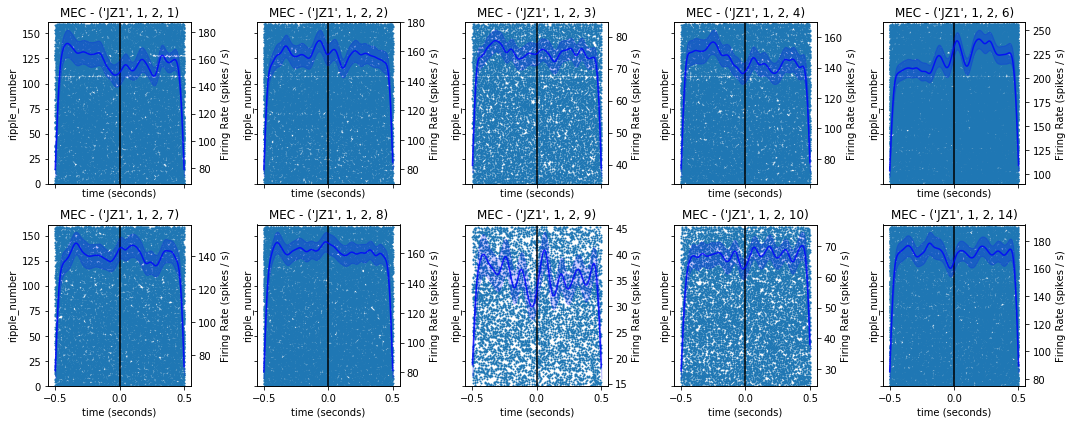

In [148]:
from src.visualization import plot_perievent_raster

mec_keys = mec_ntrode_df.index
n_tetrodes = len(mec_keys)
col_wrap = 5
n_rows = np.ceil(n_tetrodes / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, tetrode_key in zip(axes.ravel(), mec_keys):
    mecaxplot, mecspikes, mecevent_locked_spikes, meckde = plot_perievent_raster(tetrode_key, ANIMALS, ripple_times,
                          ntrode_df, window_offset=(-0.5, 0.5),
                          ax=ax, s=1)

for ax in axes.ravel()[n_tetrodes:]:
    ax.axis('off')
plt.tight_layout()

In [ ]:
epoch_index_e4 = ('JZ1', 1, 4)

mec_ntrode_df_e4 = ntrode_df.xs(epoch_index_e4, drop_level=False)[ntrode_df.area.isin(['mec'])]
ca1_ntrode_df_e4 = ntrode_df.xs(epoch_index_e4, drop_level=False)[ntrode_df.area.isin(['ca1'])]

position_variables = ['linear_distance', 'trajectory_direction', 'speed']
position_df_e4 = lfdp.get_interpolated_position_dataframe(epoch_index_e4, animals)
# add the time index values as another col
position_df_e4['time'] = position_df_e4.index
hippocampus_lfps = lfdp.get_LFPs(ca1_ntrode_df_e4.index, animals)
time = hippocampus_lfps.index
sampling_frequency = 1500
ripple_times = ripple.Kay_ripple_detector(
    time, hippocampus_lfps.values, position_df_e4.speed.values, sampling_frequency,
    minimum_duration=pd.Timedelta(milliseconds=15), zscore_threshold=4)

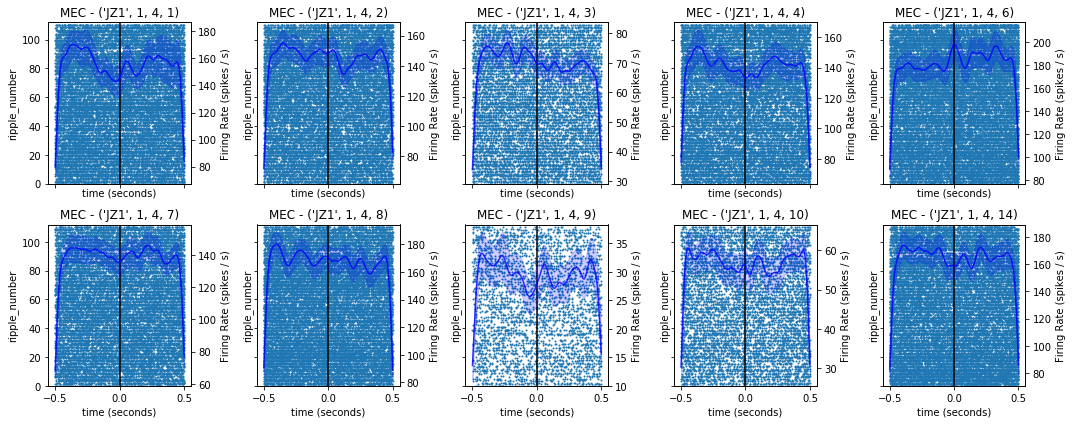

In [194]:
mec_keys = mec_ntrode_df_e4.index
n_tetrodes = len(mec_keys)
col_wrap = 5
n_rows = np.ceil(n_tetrodes / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, tetrode_key in zip(axes.ravel(), mec_keys):
    mecaxplot, mecspikes, mecevent_locked_spikes, meckde = plot_perievent_raster(tetrode_key, ANIMALS, ripple_times,
                          ntrode_df, window_offset=(-0.5, 0.5),
                          ax=ax, s=1)

for ax in axes.ravel()[n_tetrodes:]:
    ax.axis('off')
plt.tight_layout()

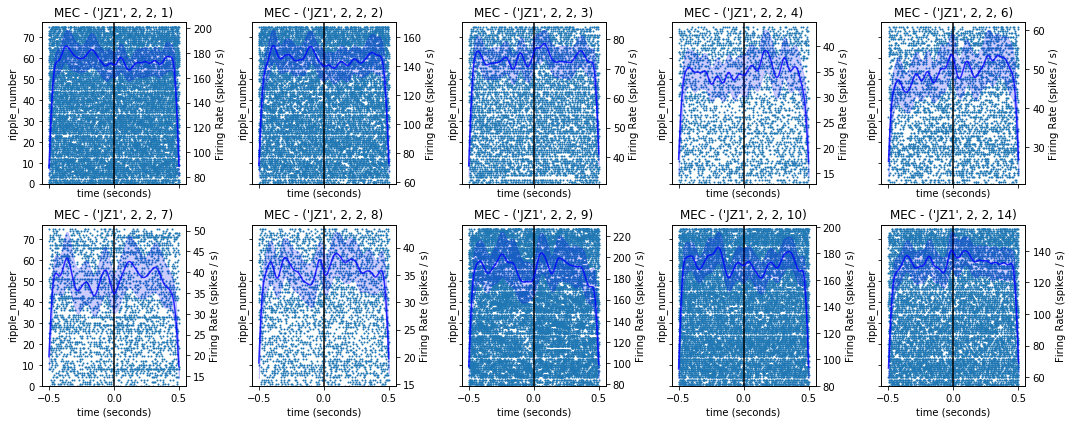

In [198]:
epoch_index_d2_e2 = ('JZ1', 2, 2)

mec_ntrode_df_d2_e2 = ntrode_df.xs(epoch_index_d2_e2, drop_level=False)[ntrode_df.area.isin(['mec'])]
ca1_ntrode_df_d2_e2 = ntrode_df.xs(epoch_index_d2_e2, drop_level=False)[ntrode_df.area.isin(['ca1'])]

position_variables = ['linear_distance', 'trajectory_direction', 'speed']
position_df_d2_e2 = lfdp.get_interpolated_position_dataframe(epoch_index_d2_e2, animals)
# add the time index values as another col
position_df_d2_e2['time'] = position_df_d2_e2.index
hippocampus_lfps = lfdp.get_LFPs(ca1_ntrode_df_d2_e2.index, animals)
time = hippocampus_lfps.index
sampling_frequency = 1500
ripple_times_d2_e2 = ripple.Kay_ripple_detector(
    time, hippocampus_lfps.values, position_df_d2_e2.speed.values, sampling_frequency,
    minimum_duration=pd.Timedelta(milliseconds=15), zscore_threshold=4)

mec_keys = mec_ntrode_df_d2_e2.index
n_tetrodes = len(mec_keys)
col_wrap = 5
n_rows = np.ceil(n_tetrodes / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, tetrode_key in zip(axes.ravel(), mec_keys):
    mecaxplot, mecspikes, mecevent_locked_spikes, meckde = plot_perievent_raster(tetrode_key, ANIMALS, ripple_times_d2_e2,
                          ntrode_df, window_offset=(-0.5, 0.5),
                          ax=ax, s=1)

for ax in axes.ravel()[n_tetrodes:]:
    ax.axis('off')
plt.tight_layout()

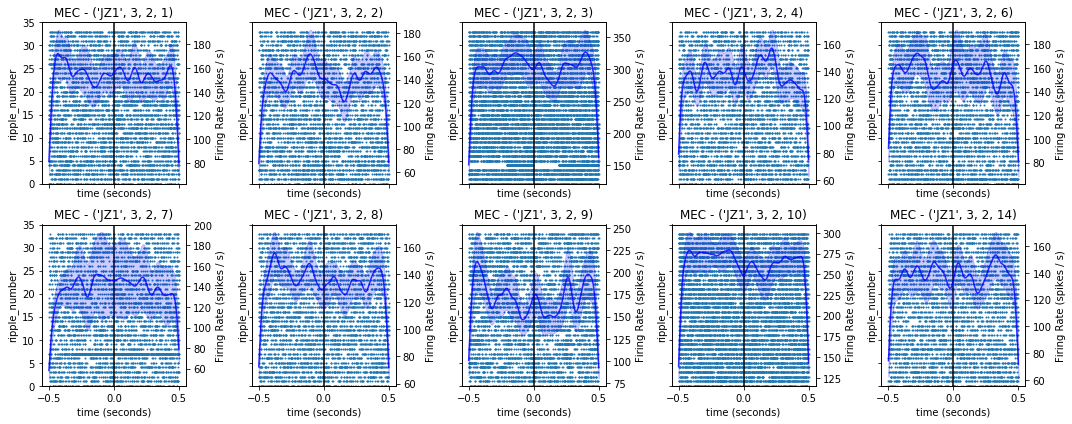

In [199]:
epoch_index_d3_e2 = ('JZ1', 3, 2)

mec_ntrode_df_d3_e2 = ntrode_df.xs(epoch_index_d3_e2, drop_level=False)[ntrode_df.area.isin(['mec'])]
ca1_ntrode_df_d3_e2 = ntrode_df.xs(epoch_index_d3_e2, drop_level=False)[ntrode_df.area.isin(['ca1'])]

position_variables = ['linear_distance', 'trajectory_direction', 'speed']
position_df_d3_e2 = lfdp.get_interpolated_position_dataframe(epoch_index_d3_e2, animals)
# add the time index values as another col
position_df_d3_e2['time'] = position_df_d3_e2.index
hippocampus_lfps = lfdp.get_LFPs(ca1_ntrode_df_d3_e2.index, animals)
time = hippocampus_lfps.index
sampling_frequency = 1500
ripple_times_d3_e2 = ripple.Kay_ripple_detector(
    time, hippocampus_lfps.values, position_df_d3_e2.speed.values, sampling_frequency,
    minimum_duration=pd.Timedelta(milliseconds=15), zscore_threshold=4)

mec_keys = mec_ntrode_df_d3_e2.index
n_tetrodes = len(mec_keys)
col_wrap = 5
n_rows = np.ceil(n_tetrodes / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, tetrode_key in zip(axes.ravel(), mec_keys):
    mecaxplot, mecspikes, mecevent_locked_spikes, meckde = plot_perievent_raster(tetrode_key, ANIMALS, ripple_times_d3_e2,
                          ntrode_df, window_offset=(-0.5, 0.5),
                          ax=ax, s=1)

for ax in axes.ravel()[n_tetrodes:]:
    ax.axis('off')
plt.tight_layout()

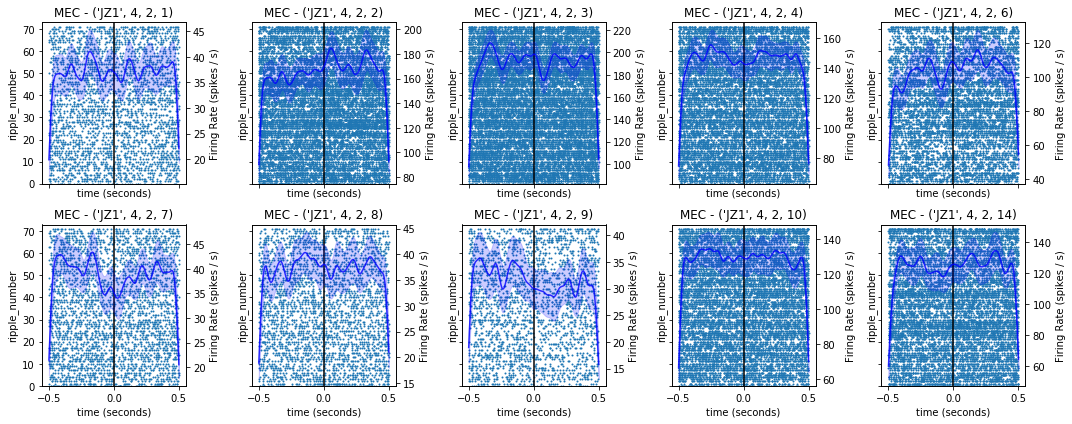

In [200]:
epoch_index_d6_e2 = ('JZ1', 4, 2)

mec_ntrode_df_d6_e2 = ntrode_df.xs(epoch_index_d6_e2, drop_level=False)[ntrode_df.area.isin(['mec'])]
ca1_ntrode_df_d6_e2 = ntrode_df.xs(epoch_index_d6_e2, drop_level=False)[ntrode_df.area.isin(['ca1'])]

position_variables = ['linear_distance', 'trajectory_direction', 'speed']
position_df_d6_e2 = lfdp.get_interpolated_position_dataframe(epoch_index_d6_e2, animals)
# add the time index values as another col
position_df_d6_e2['time'] = position_df_d6_e2.index
hippocampus_lfps = lfdp.get_LFPs(ca1_ntrode_df_d6_e2.index, animals)
time = hippocampus_lfps.index
sampling_frequency = 1500
ripple_times_d6_e2 = ripple.Kay_ripple_detector(
    time, hippocampus_lfps.values, position_df_d6_e2.speed.values, sampling_frequency,
    minimum_duration=pd.Timedelta(milliseconds=15), zscore_threshold=4)

mec_keys = mec_ntrode_df_d6_e2.index
n_tetrodes = len(mec_keys)
col_wrap = 5
n_rows = np.ceil(n_tetrodes / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, tetrode_key in zip(axes.ravel(), mec_keys):
    mecaxplot, mecspikes, mecevent_locked_spikes, meckde = plot_perievent_raster(tetrode_key, ANIMALS, ripple_times_d6_e2,
                          ntrode_df, window_offset=(-0.5, 0.5),
                          ax=ax, s=1)

for ax in axes.ravel()[n_tetrodes:]:
    ax.axis('off')
plt.tight_layout()

In [201]:
epoch_index_d5_e2 = ('JZ1', 5, 2)

mec_ntrode_df_d5_e2 = ntrode_df.xs(epoch_index_d5_e2, drop_level=False)[ntrode_df.area.isin(['mec'])]
ca1_ntrode_df_d5_e2 = ntrode_df.xs(epoch_index_d5_e2, drop_level=False)[ntrode_df.area.isin(['ca1'])]

position_variables = ['linear_distance', 'trajectory_direction', 'speed']
position_df_d5_e2 = lfdp.get_interpolated_position_dataframe(epoch_index_d5_e2, animals)
# add the time index values as another col
position_df_d5_e2['time'] = position_df_d5_e2.index
hippocampus_lfps = lfdp.get_LFPs(ca1_ntrode_df_d5_e2.index, animals)
time = hippocampus_lfps.index
sampling_frequency = 1500
ripple_times_d5_e2 = ripple.Kay_ripple_detector(
    time, hippocampus_lfps.values, position_df_d5_e2.speed.values, sampling_frequency,
    minimum_duration=pd.Timedelta(milliseconds=15), zscore_threshold=4)

mec_keys = mec_ntrode_df_d5_e2.index
n_tetrodes = len(mec_keys)
col_wrap = 5
n_rows = np.ceil(n_tetrodes / col_wrap).astype(int)

fig, axes = plt.subplots(n_rows, col_wrap, figsize=(col_wrap * 3, n_rows * 3), sharex=True, sharey=True)
for ax, tetrode_key in zip(axes.ravel(), mec_keys):
    mecaxplot, mecspikes, mecevent_locked_spikes, meckde = plot_perievent_raster(tetrode_key, ANIMALS, ripple_times_d5_e2,
                          ntrode_df, window_offset=(-0.5, 0.5),
                          ax=ax, s=1)

for ax in axes.ravel()[n_tetrodes:]:
    ax.axis('off')
plt.tight_layout()

KeyboardInterrupt: 

In [167]:
os.system('subl ~/anaconda3/envs/Roumis_2018/lib/python3.6/site-packages/loren_frank_data_processing/multiunit.py')

0